In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(18,8))
plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33823 instead
  warnings.warn(
/home/durandy/miniconda3/envs/towel/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


<Client: 'inproc://137.129.155.67/5873/1' processes=1 threads=4, memory=78.61 GiB>

In [2]:
indir_smot = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/SMOTHED_CLIM/'
indir_brut = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_CLIM/'
output_fig = '/cnrm/tropics/commun/DATACOMMUN/WAVE/RAPPORT/FIGURES/CLIM/'

var = 'tcwv'

ds_brut = xr.open_mfdataset(indir_brut+'clim_toa_lw_all_1h_brut_ERA5_3H_2000_2020.nc', chunks = {'time' : 1}, engine="h5netcdf", parallel=True)
ds_smot = xr.open_mfdataset(indir_smot+'clim_OLR_smooth_ERA5_2000_2020.nc', chunks = {'time' : 1}, engine="h5netcdf", parallel=True)

ds_brut = ds_brut.sel(lat = slice(-30.1,30.1))
ds_smot = ds_smot.sel(lat = slice(-30.1,30.1))

ds_brut


<xarray.Dataset>
Dimensions:        (time: 2928, lat: 60, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 1904-01-01 ... 1904-12-31T21:00:00
  * lat            (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon            (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    toa_lw_all_1h  (time, lat, lon) float32 dask.array<chunksize=(1, 60, 360), meta=np.ndarray>

# Verification 1D entre les données brutes et les données smoothed
Cette vérification est faite sur trois points du globe, Afrique, Océan Indien et Océan Pacifique

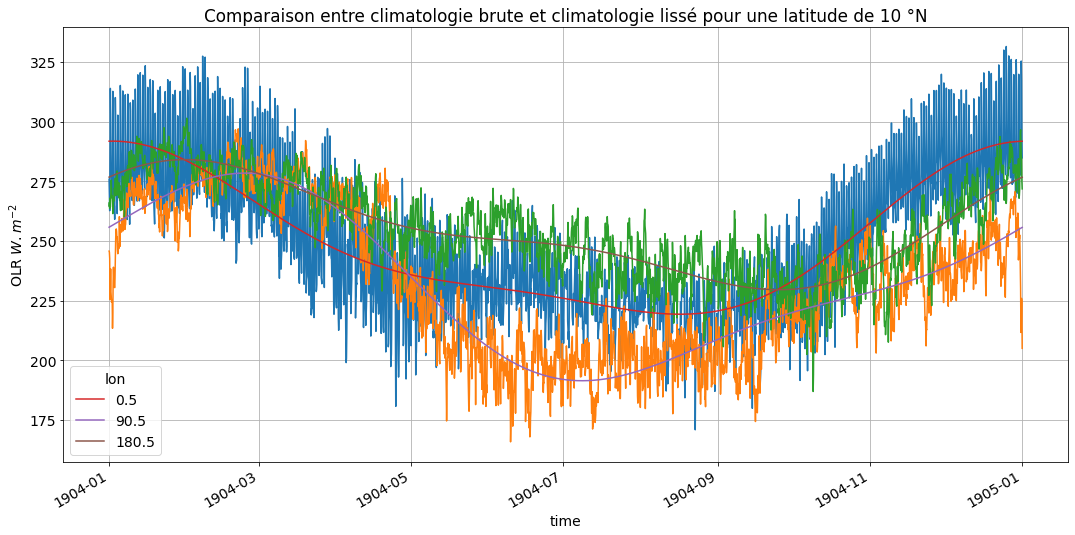

In [4]:
lat = 10
lon = [0, 90, 180]

plt.figure()
ds_brut['toa_lw_all_1h'].sel(lat = lat, lon = lon, method = 'nearest').plot(hue='lon')
ds_smot['toa_lw_all_1h'].sel(lat = lat, lon = lon, method = 'nearest').plot(hue='lon')
plt.grid()
plt.title('Comparaison entre climatologie brute et climatologie lissé pour une latitude de 10 °N')
plt.ylabel('OLR $W.m^{-2}$')
# plt.legend()
plt.show()

# Verification 2D

In [79]:
# ds_MMS = ds_smot.groupby('time.month').mean('time').load()
# ds_MSS = ds_smot.groupby('time.season').mean('time').load()
ds_mean = ds_smot.mean('time').load()


#### Carte global de PW en moyenne mensuelle

In [83]:
vmax = 350.
vmin = 150.
#### Parameter for plotting
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax+0.1,10),
            'extend' : 'both'}

cmap = 'viridis'
size = 5
aspect = 6
map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-40.0, 
                         max_latitude=40.0, 
                         globe=None)

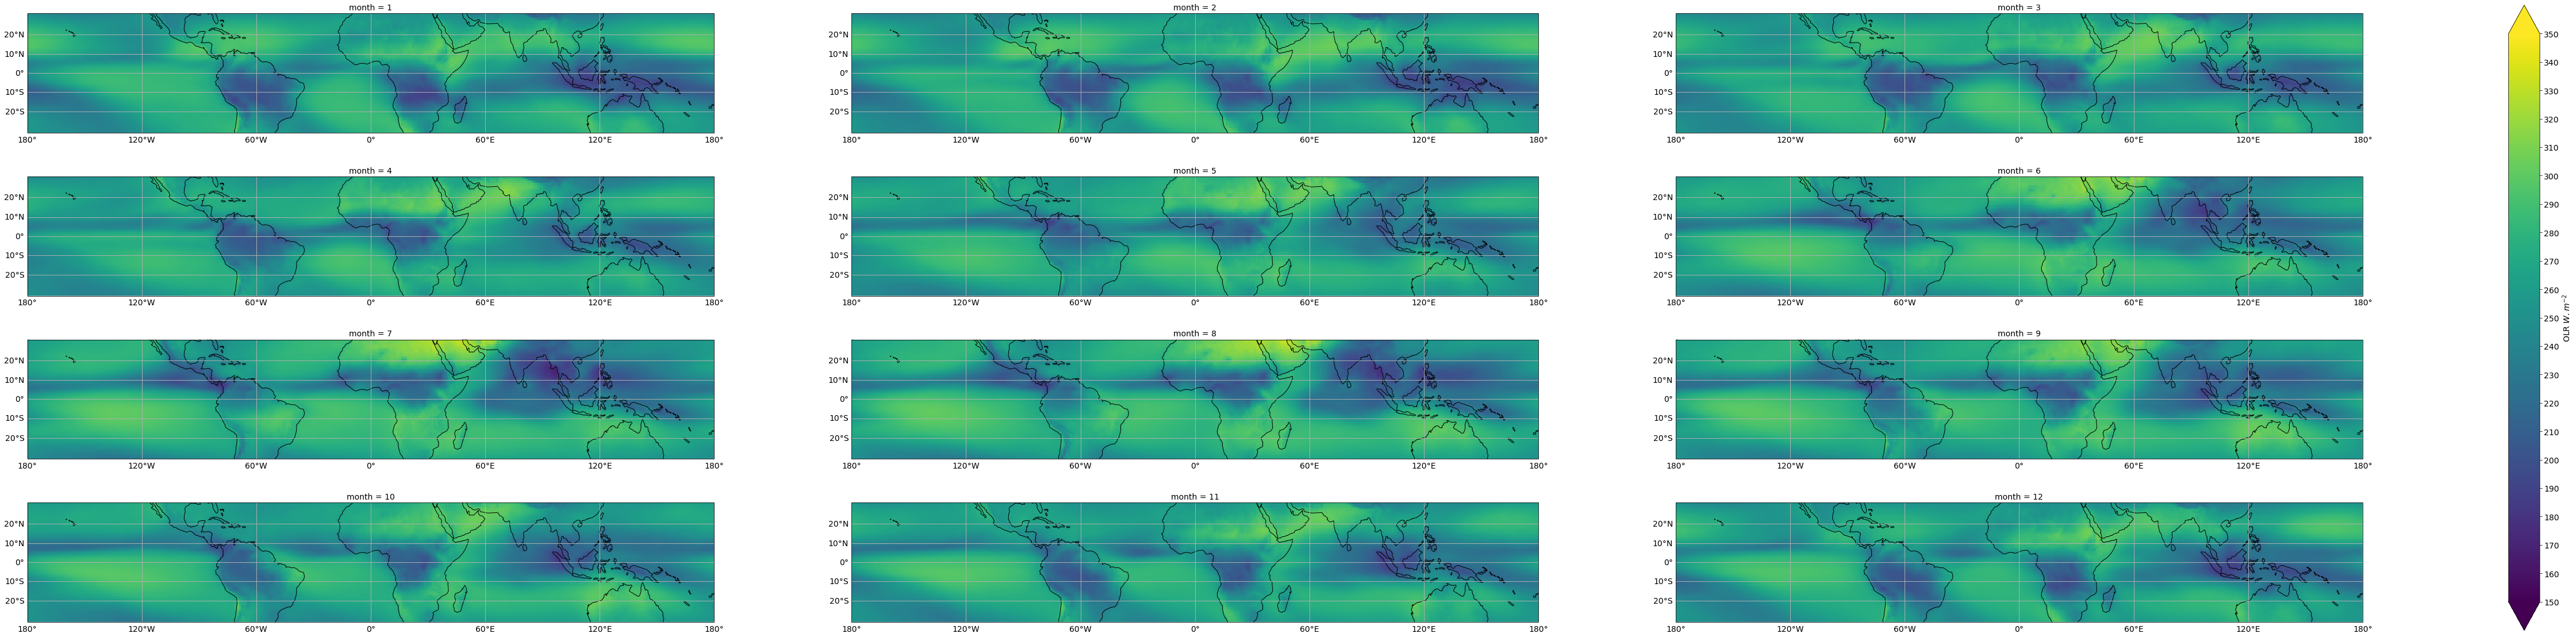

In [38]:


# plt.figure(figsize = (30,10))
p = ds_MMS['toa_lw_all_1h'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_meanMonth_clim.png')  

#### Carte global de PW en moyenne saisonière

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


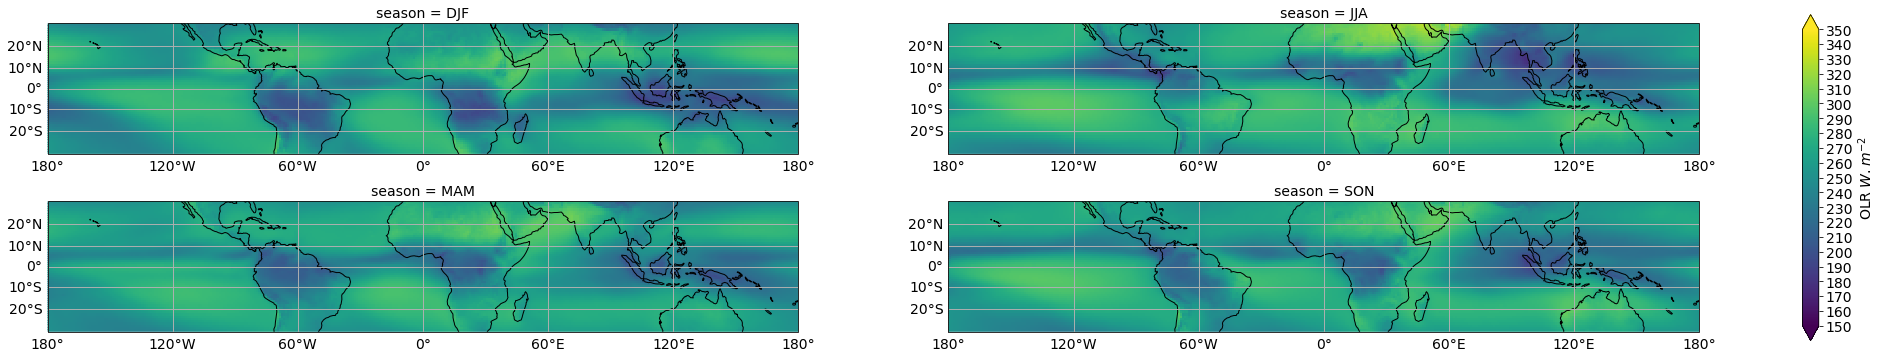

In [81]:
size = 3
aspect = 6

p = ds_MSS['toa_lw_all_1h'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_meanSeason_clim.png')

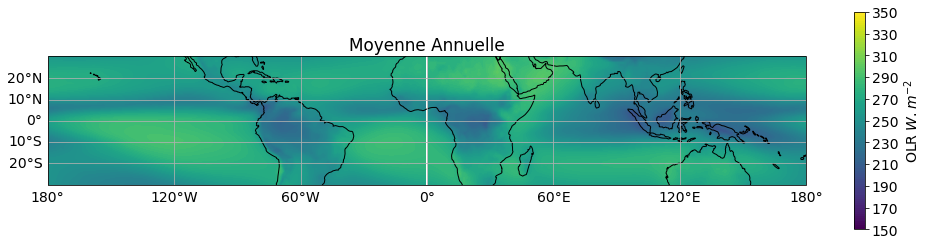

<Figure size 1224x288 with 0 Axes>

In [88]:
plt.rc("figure", figsize=(17,4))

colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax +.1,20),
            'extend' : 'max'}

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.1, 
                         max_latitude=30.1,
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_mean['toa_lw_all_1h'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , vmin = vmin, vmax = vmax,
                    cbar_kwargs=colorbar)
                    

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title('Moyenne Annuelle')
plt.show()

plt.savefig(output_fig+'atlas_meanSeason_clim.png')

# Calcul et carte de variance pour la variable tcwv

In [52]:
ds_std_smot = ds_smot.std('time').load()
# ds_std_smot_M = ds_smot.groupby('time.month').std('time').load()
# ds_std_smot_S = ds_smot.groupby('time.season').std('time').load()

# ds_std_brut = ds_brut.std('time')
# ds_std_brut_M = ds_brut.groupby('time.month').std('time')
# ds_std_brut_S= ds_brut.groupby('time.season').std('time')

In [64]:
vmax = 10.
vmin = 0.
#### Parameter for plotting
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax + .1 ,2),
            'extend' : 'max'}

cmap ='viridis'
size = 5
aspect = 6

#### Atlas de la variance sur les douze mois 

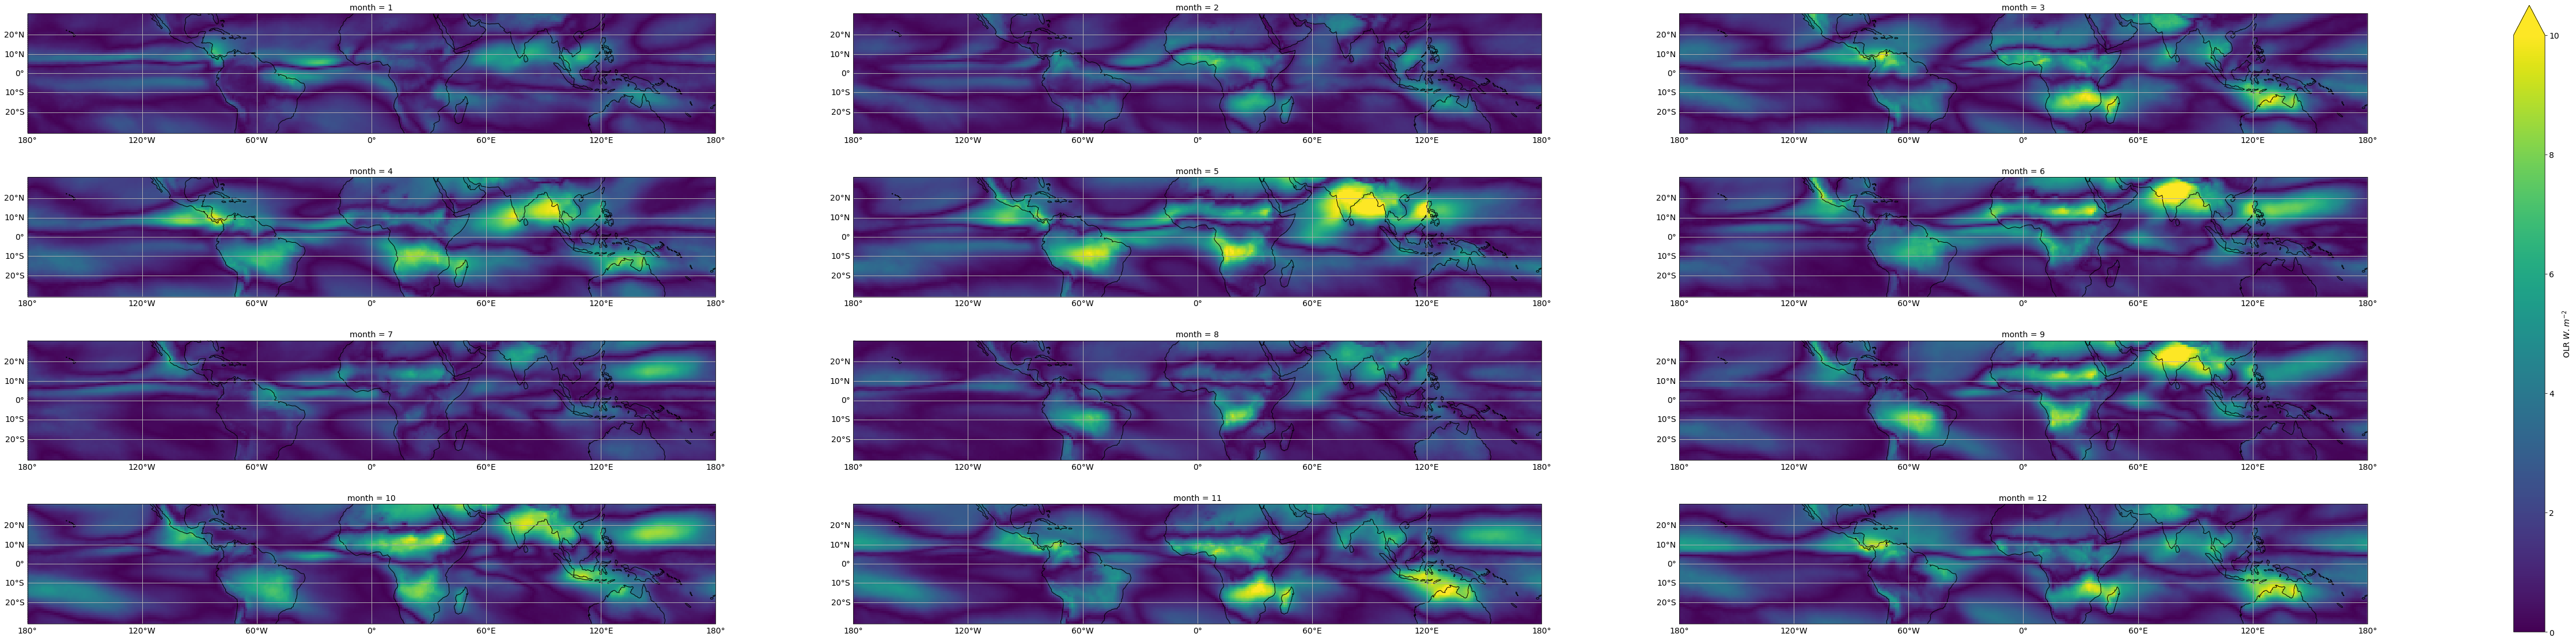

In [65]:
p = ds_std_smot_M['toa_lw_all_1h'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'month', col_wrap =3,
                               aspect = aspect, size = size,
                               vmin = 0., vmax = vmax, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                               cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_meanSeason_clim.png')
# plt.show()
plt.savefig(output_fig+'atlas_varMonth_clim.png')

#### Atlas de la variance saisonière

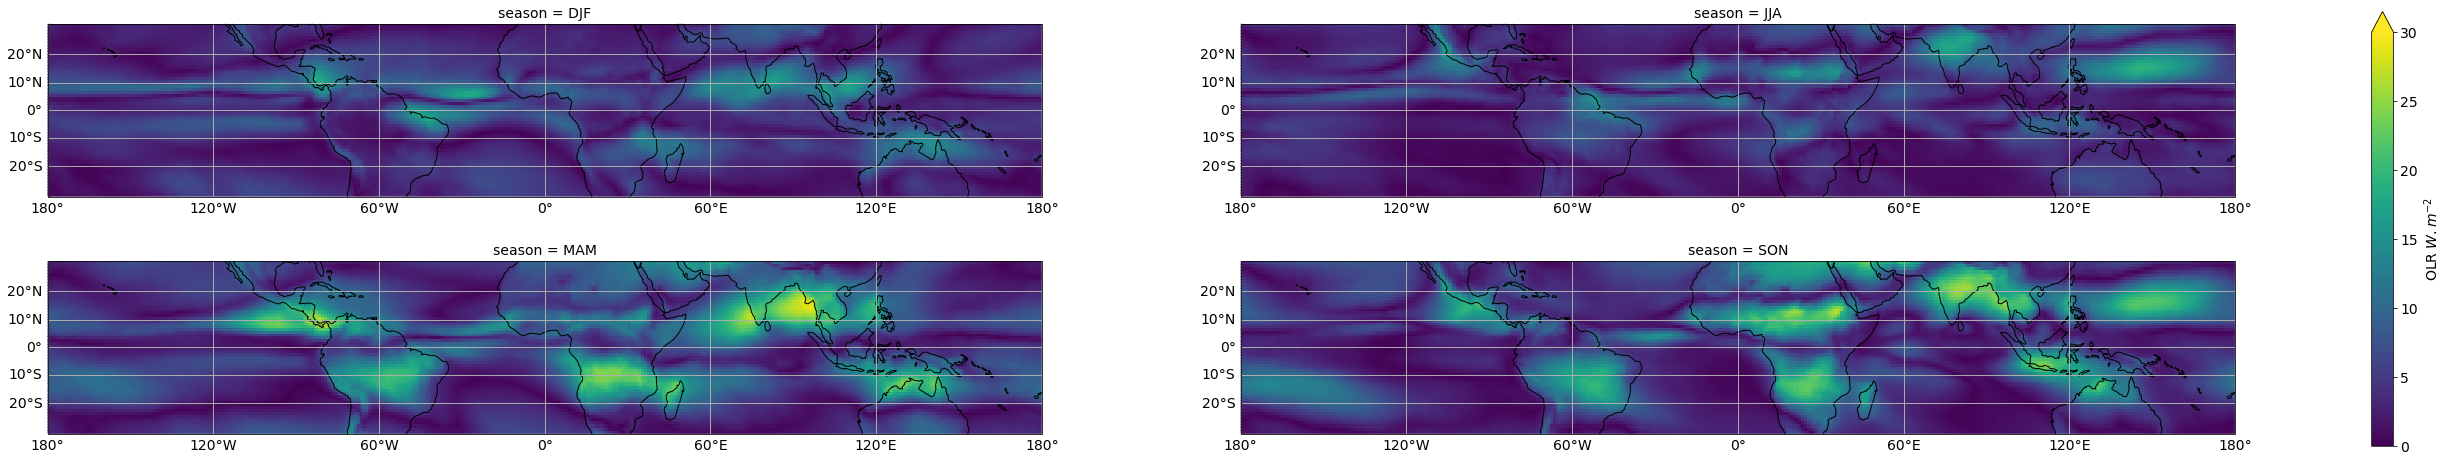

In [67]:
colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax*3 + .1 ,5),
            'extend' : 'max'}

size = 4
aspect = 6

p = ds_std_smot_S['toa_lw_all_1h'].plot(transform=ccrs.PlateCarree(),  # the data's projection
                               col = 'season', col_wrap =2,
                               aspect = aspect, size = size,
                               vmin = vmin, vmax = vmax*3, cmap=cmap,# multiplot settings
                               subplot_kws={'projection': map_proj},
                              cbar_kwargs=colorbar)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
plt.savefig(output_fig+'atlas_meanSeason_clim.png')
plt.savefig(output_fig+'atlas_varSeason_clim.png')

#### Variance sur l'année

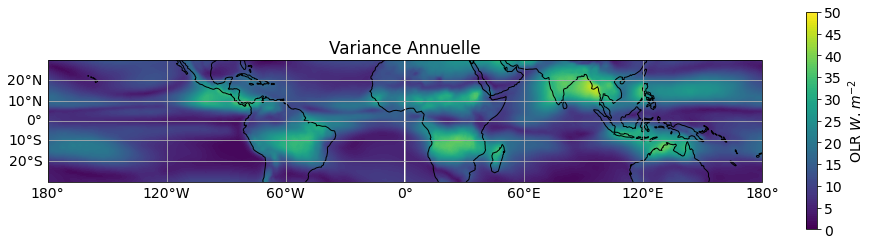

<Figure size 1152x288 with 0 Axes>

In [78]:
plt.rc("figure", figsize=(16,4))

colorbar = {'label': 'OLR $W.m^{-2}$',
            'orientation': 'vertical' , 'ticks': np.arange(vmin,vmax*5 + .1 ,5),
            'extend' : 'max'}

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.1, 
                         max_latitude=30.1,
                         globe=None)

fig, axis = plt.subplots(
    1, 1, subplot_kw={'projection': map_proj})

ds_std_smot['toa_lw_all_1h'].plot.contourf(ax=axis, levels = 101, 
                    transform=ccrs.PlateCarree(),
                    cmap=cmap , vmin = vmin, vmax = vmax*5,
                    cbar_kwargs=colorbar)
                    

axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.title('Variance Annuelle')
plt.show()

plt.savefig(output_fig+'atlas_meanSeason_clim.png')